In [1]:
# Don't modify this cell.
# Dependencies and Setup
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import statistics
import requests
import time
import math
from scipy import stats
from pprint import pprint

# Import API key
from api_keys import api_key

#import ready packages
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.cryptocurrencies import CryptoCurrencies

In [2]:
#Using existing alpha_vantage packages:

def get_crypto(sym, mar):
    ccb = CryptoCurrencies(key=api_key, output_format='pandas')
    data, meta_data = ccb.get_digital_currency_daily(symbol=sym, market=mar)
    data = data.drop(columns = ['1a. open (USD)', '1b. open (USD)', '2a. high (USD)', '2b. high (USD)',
       '3a. low (USD)', '3b. low (USD)', '4a. close (USD)',
       '5. volume', '6. market cap (USD)'])
    data = data.rename(columns = {'4b. close (USD)' : f'{sym} (USD)'})
    return data, meta_data

b_data, b_meta_data = get_crypto('BTC', 'USD')
e_data, e_meta_data = get_crypto('ETH', 'USD')

crypto_data = pd.concat([b_data, e_data], axis = 1)
crypto_data.head(1)

,BTC (USD),ETH (USD)
date,,
2021-11-08,64671.9,4671.34


In [26]:
def plot_correlations(df, roll, location1, location2, delta):
    columns = df.columns.to_list()
    
    fig = plt.figure(figsize = (15, 17))
    ax1 = fig.add_subplot(3, 1, 1)
    ax2 = fig.add_subplot(3, 1, 2)
    ax3 = fig.add_subplot(3, 1, 3, sharex = ax2)
    
    fig.tight_layout(pad = 8.0)
    
    ax1.scatter(df[columns[0]], df[columns[1]])
    ax1.set_xlabel(f'Price of {columns[0]}', color = 'r')
    ax1.set_ylabel(f'Price of {columns[1]}', color = 'b')
    ax1.title.set_text(f'Scatterplot of {columns[0]} and {columns[1]} Prices')
    ax1.tick_params('x', colors = 'r', labelbottom = True)
    ax1.tick_params('y', colors = 'b')
    
    ax2.plot(df.index, df[columns[0]], c = 'r')
    ax2.set_xlabel('Date')
    ax2.set_ylabel(f'Price of {columns[0]}', color = 'r')
    ax2.title.set_text(f'Time Series of {columns[0]} and {columns[1]} Prices')
    ax2.tick_params('y', colors = 'r')
    ax2.tick_params('x', labelbottom = True)

    ax4 = ax2.twinx()
    ax4.plot(df.index, df[columns[1]], c = 'b')
    ax4.set_ylabel(f'Price of {columns[1]}', color = 'b')
    ax4.tick_params('y', colors = 'b', labelbottom = True)
    
    ax3.plot(df[columns[0]].rolling(window = roll).corr(df[columns[1]]).shift(periods = -(roll-1)))
    ax3.axhline(df.corr().iloc[0,1], c = 'r')
    ax3.set_xlabel('Date')
    ax3.set_ylabel('45 day rolling correlation between' '\n' f'{columns[0]} and {columns[1]} prices')
    ax3.title.set_text(f'Rolling Correlation Analysis of {columns[0]} and {columns[1]} Prices')
    ax3.annotate('global correlation coefficient', 
               xy = [pd.Timestamp(location1), df.corr().iloc[0,1]], xytext = [pd.Timestamp(location2), df.corr().iloc[0,1] - delta], arrowprops = {})
    
    print(df.corr())
    
   

           BTC (USD)  ETH (USD)
BTC (USD)   1.000000   0.921622
ETH (USD)   0.921622   1.000000


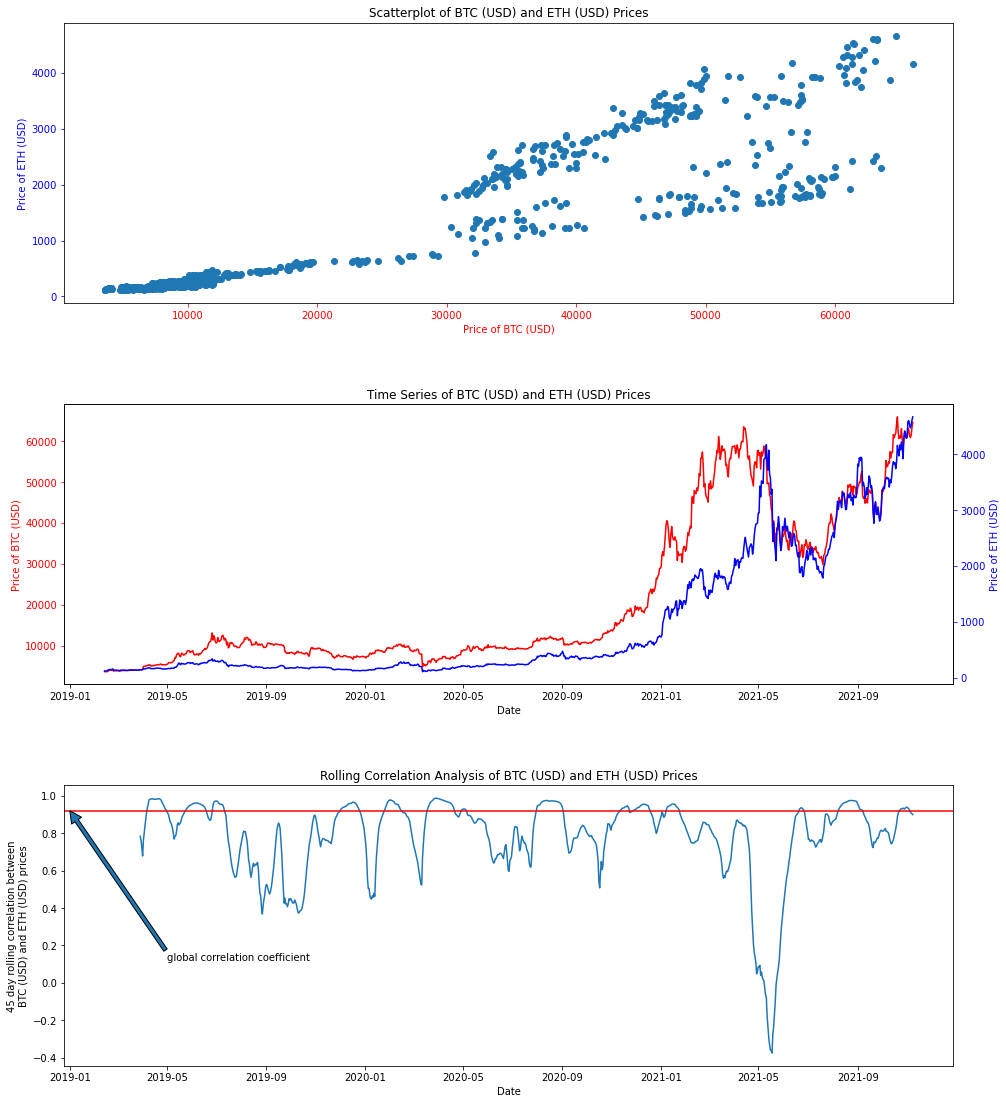

In [28]:
plot_correlations(crypto_data, 45, '2019-01', '2019-05', 0.8)

<Figure size 360x288 with 0 Axes>

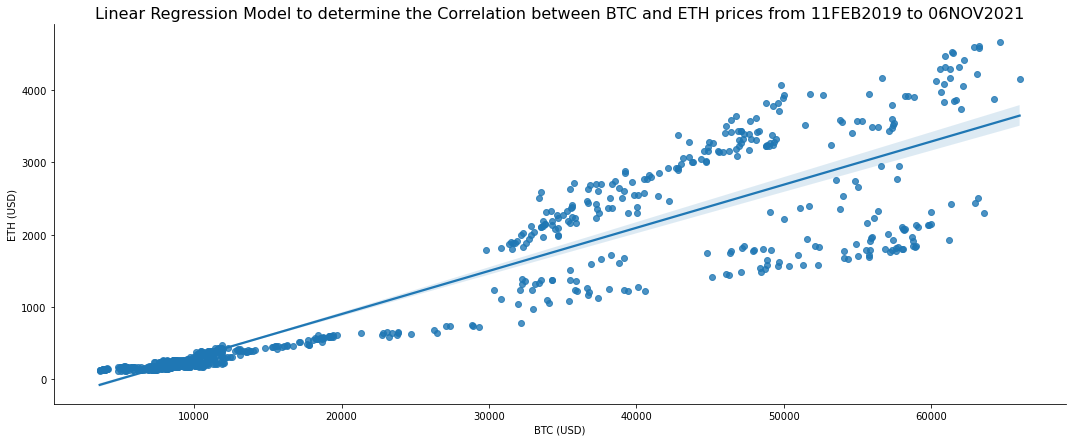

In [29]:
plt.figure(figsize=(5, 4))
sns.lmplot(x="BTC (USD)", y="ETH (USD)", data=crypto_data, height=6, aspect=2.5)
plt.title("Linear Regression Model to determine the Correlation between BTC and ETH prices from 11FEB2019 to 06NOV2021", fontsize=16)
plt.show()

In [30]:
def get_stock(sym):

    ts = TimeSeries(key= api_key, output_format='pandas')
    data, meta_data = ts.get_daily(symbol=sym, outputsize='full')
    data = data.drop(columns = ['1. open', '2. high', '3. low', '5. volume'])
    data = data.rename(columns = {'4. close': f'{sym} (USD)'})
    return data, meta_data

spy_data, spy_meta_data = get_stock('SPY')

spy_btc_data = b_data.join(spy_data, how = 'inner')
spy_btc_data.tail(1)

,BTC (USD),SPY (USD)
date,,
2019-02-13,3609.4,274.99


           BTC (USD)  SPY (USD)
BTC (USD)   1.000000   0.894286
SPY (USD)   0.894286   1.000000


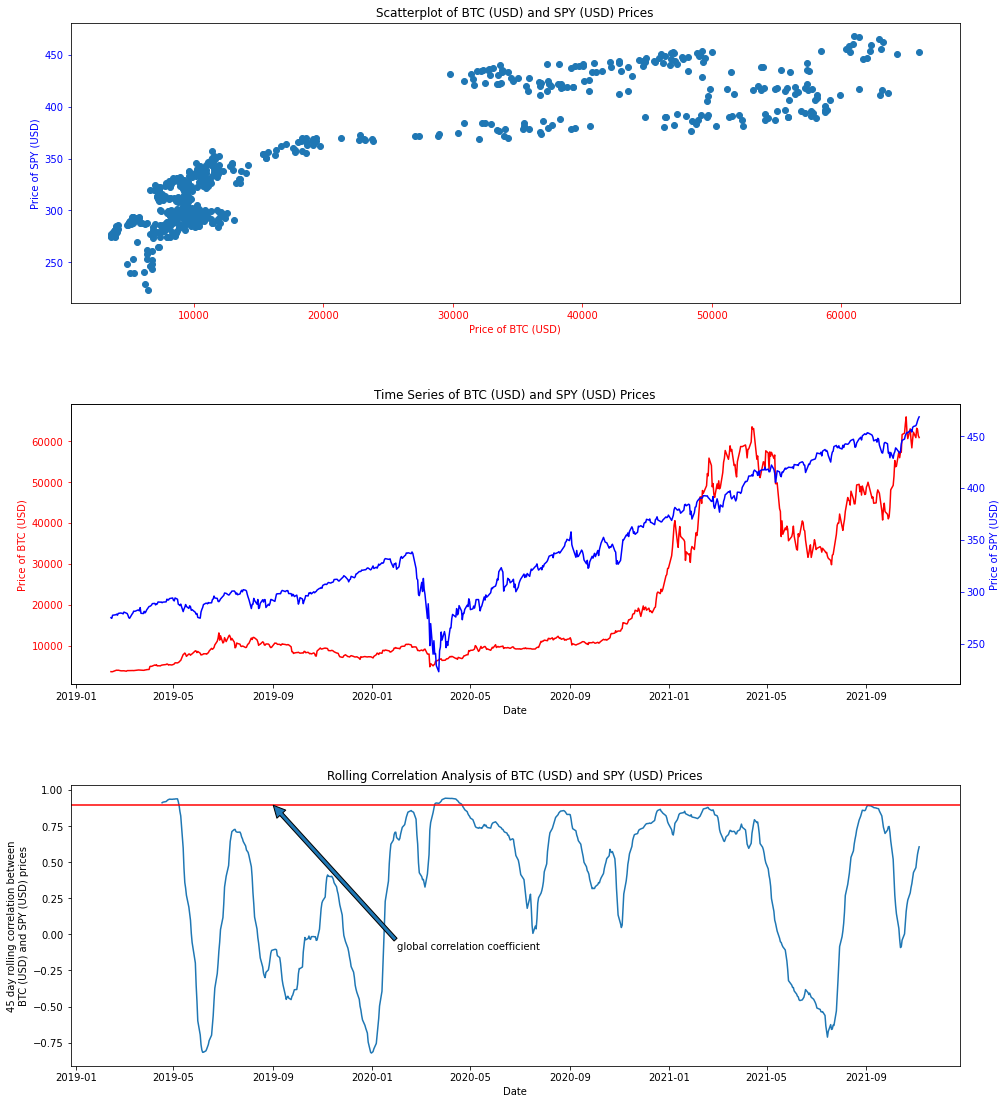

In [31]:
plot_correlations(spy_btc_data, 45, '2019-09', '2020-02', 1)

In [32]:
hive_data, hive_meta_data = get_stock('HIVE')

hive_btc_data = b_data.join(hive_data, how = 'inner')
hive_btc_data.tail(1)

,BTC (USD),HIVE (USD)
date,,
2019-02-13,3609.4,0.294


            BTC (USD)  HIVE (USD)
BTC (USD)    1.000000    0.972767
HIVE (USD)   0.972767    1.000000


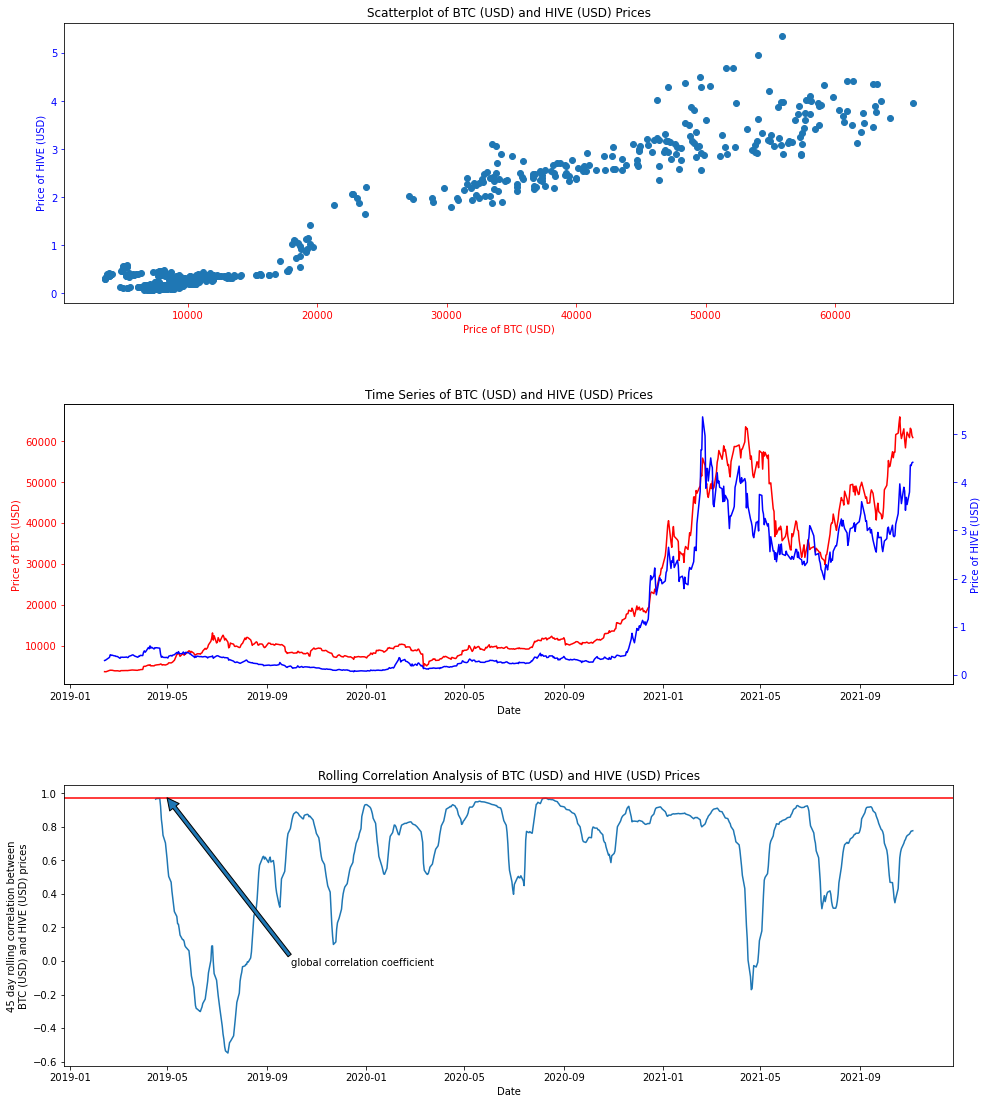

In [33]:
plot_correlations(hive_btc_data, 45, '2019-05', '2019-10', 1)

In [34]:
hive_spy_data = spy_data.join(hive_data, how = 'inner')
hive_spy_data.tail(1)

,SPY (USD),HIVE (USD)
date,,
2018-01-12,277.92,2.64


            SPY (USD)  HIVE (USD)
SPY (USD)    1.000000    0.780627
HIVE (USD)   0.780627    1.000000


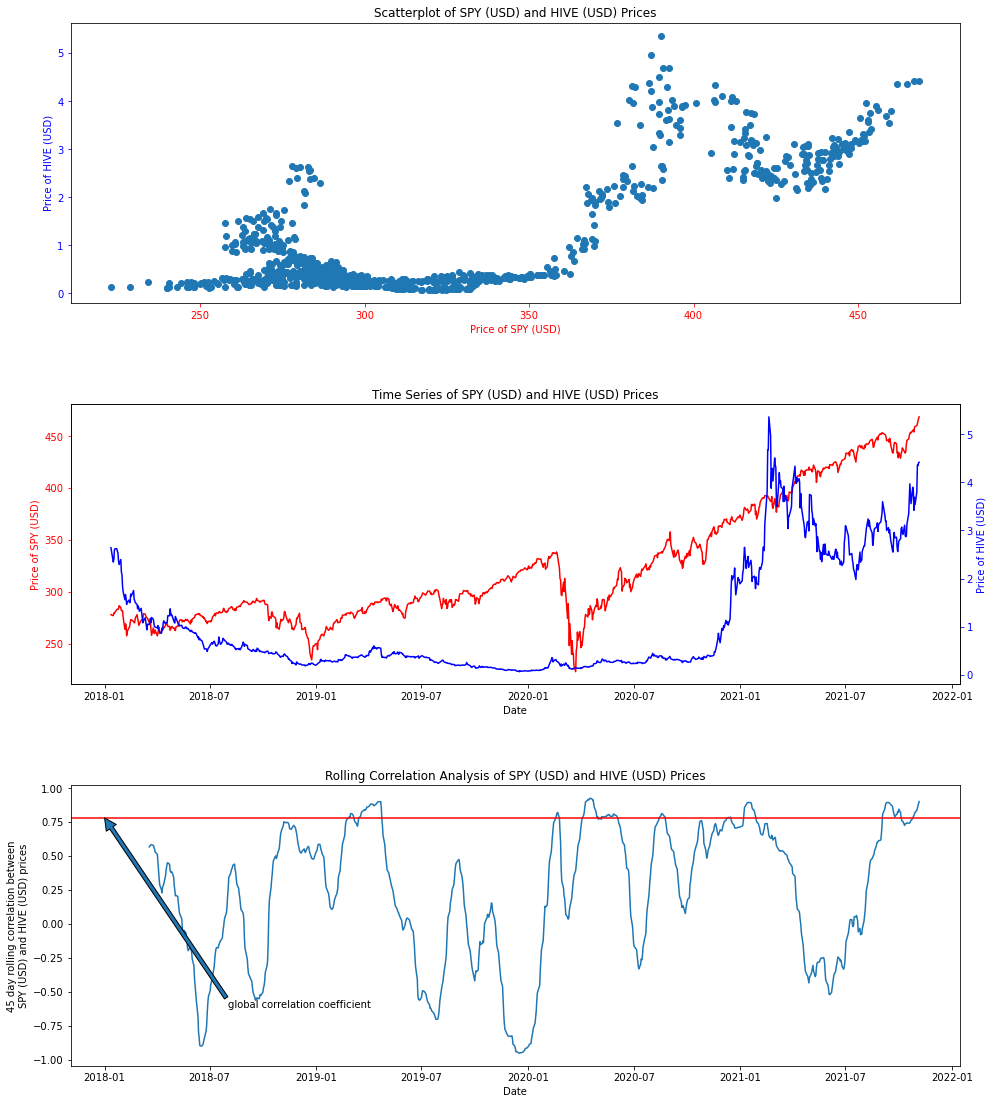

In [35]:
plot_correlations(hive_spy_data, 45, '2018-01', '2018-08', 1.4)

In [36]:
bbkcf_data, bbkcf_meta_data = get_stock('BBKCF')

bbkcf_btc_data = b_data.join(bbkcf_data, how = 'inner')
bbkcf_btc_data.tail(1)

,BTC (USD),BBKCF (USD)
date,,
2019-02-13,3609.4,0.0667


             BTC (USD)  BBKCF (USD)
BTC (USD)     1.000000     0.887539
BBKCF (USD)   0.887539     1.000000


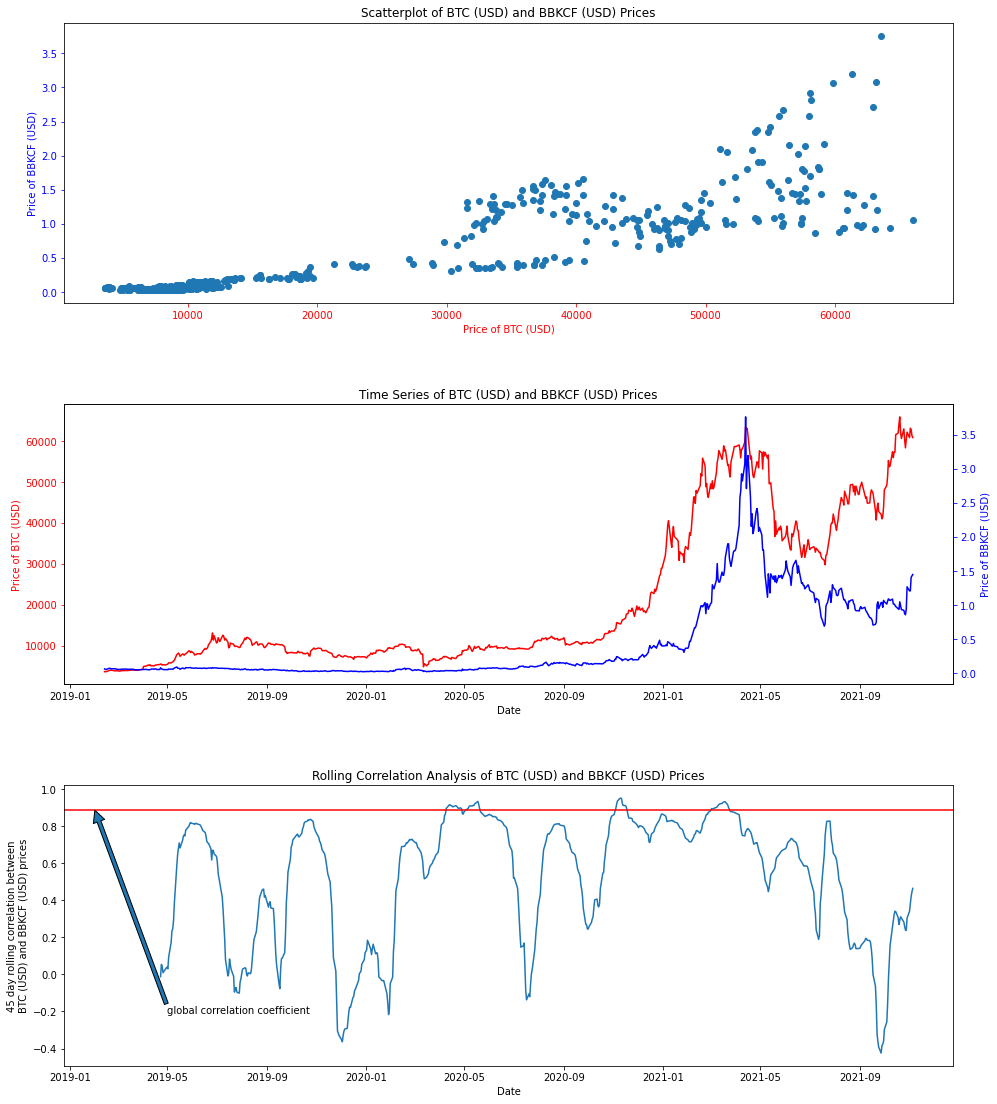

In [40]:
plot_correlations(bbkcf_btc_data, 45, '2019-02', '2019-05', 1.1)

In [41]:
bbkcf_spy_data = spy_data.join(bbkcf_data, how = 'inner')
bbkcf_spy_data.tail(1)

,SPY (USD),BBKCF (USD)
date,,
2017-12-12,266.78,1.4028


             SPY (USD)  BBKCF (USD)
SPY (USD)     1.000000     0.647477
BBKCF (USD)   0.647477     1.000000


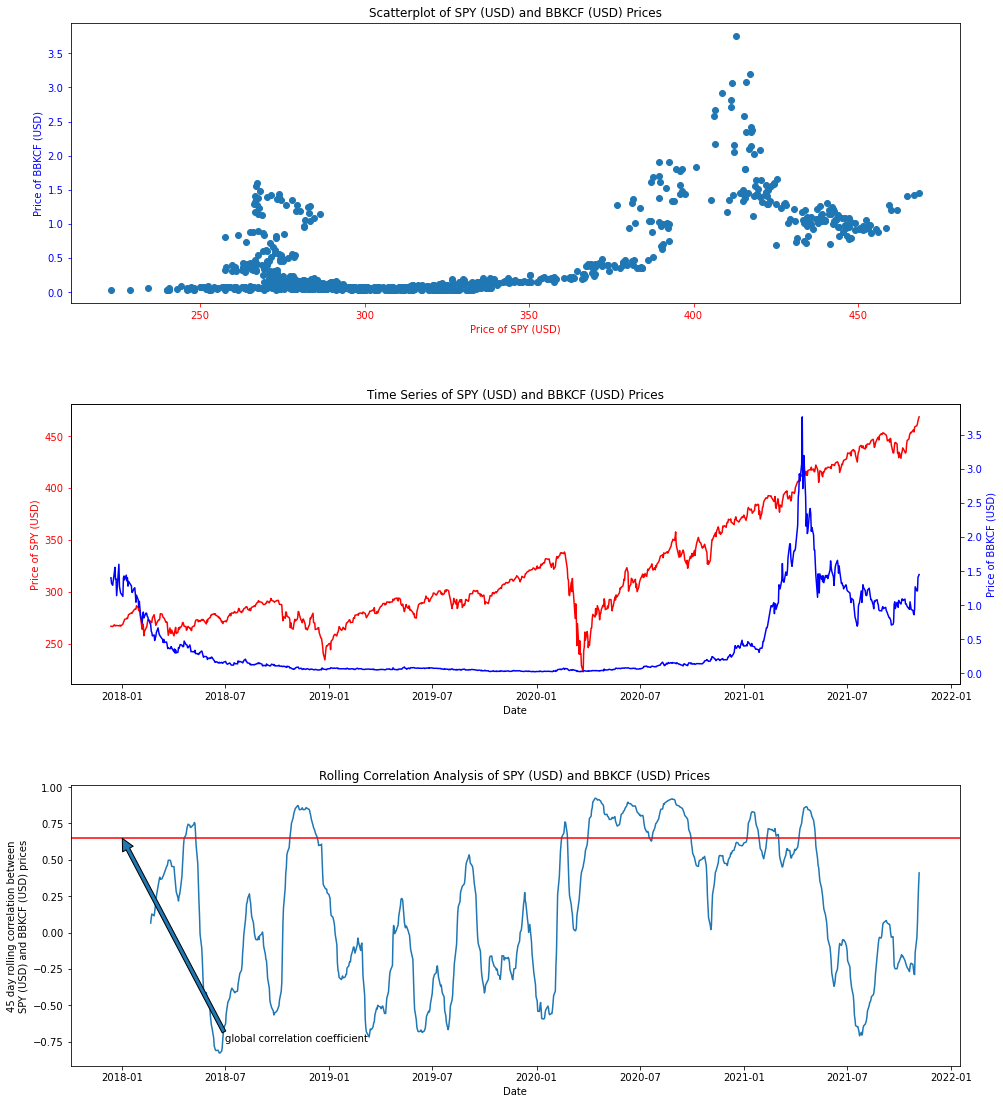

In [42]:
plot_correlations(bbkcf_spy_data, 45, '2018-01', '2018-07', 1.4)